## [DATASET](https://drive.google.com/file/d/1CIv7wheOC0TgQArukUDWjPd3tJqckmRp/view?usp=sharing)

## Add your video and poster link here

## To Classify Damaged or Undamaged Buildings Post Hurricane

### Importing the libraries and packages

In [ ]:
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Enable/Disable Eager Execution

# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

tf.random.set_seed(2266)

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import random
random.seed(112363)
import certifi
import urllib3  # For handling https certificate verification 

In [ ]:
import matplotlib.image as mp_image
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from PIL import Image

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical

!pip3 -qq install tf_keras_vis 
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam

from sklearn.metrics import confusion_matrix

## Downloading the data

In [ ]:
# Mouting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Downloading the Data if not already downloaded

if os.path.isdir('gdrive/My Drive/post_hurricane'):
    print('Found dataset' )
else:
    os.makedirs('gdrive/My Drive/post_hurricane')
    !gdown -qq https://drive.google.com/u/0/uc?id=1CIv7wheOC0TgQArukUDWjPd3tJqckmRp&export=download
    !unzip Post-hurricane.zip  -d gdrive/My\ Drive/post_hurricane/

Found dataset


###Viewing a sample Image from train_another dataset

(128, 128, 3)

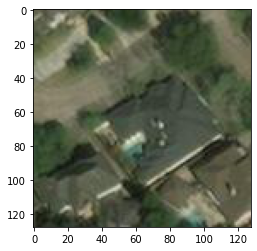

In [ ]:
img = mp_image.imread('gdrive/My Drive/post_hurricane/train_another/no_damage/-95.628215_29.776034000000003.jpeg')
plt.imshow(img)
img.shape

### Creating Data Generators for training, validation and testing the model

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
batch_size = 32

train_generator=datagen.flow_from_directory('gdrive/My Drive/post_hurricane/train_another', target_size=(224,224), shuffle = True, batch_size = batch_size)
validation_generator=datagen.flow_from_directory('gdrive/My Drive/post_hurricane/validation_another', target_size=(224,224),shuffle = True,batch_size = batch_size)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Creating the CNN Model

> We'll be using MobileNet Architecture and weights trained on the 'imagenet' dataset for part 1 of model building. Transfer learning in this scenario is helpful since a lot of data pre-processing as well as training time is saved. 

###Part 1 -  Loading the MobileNet as Base Model without the Top Layer




In [ ]:
tf.keras.backend.clear_session()
base_model=MobileNet(include_top = False, weights = 'imagenet')

17227776/17225924 [==============================] - 0s 0us/step


###Part 2 - Creating Required Layers which would be comined with Base Model

In [ ]:
x=base_model.output

x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation = 'relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x) 

In [ ]:
# Combining the Base Model and Custom Layers
model=Model(inputs = base_model.input, outputs = preds)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

> Freezing First 10 layers of MobileNet Architecture so that we can utilize their pre-trained weights

In [ ]:
for layer in model.layers[:10]:
    layer.trainable = False

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculating step-size for Training and Validation
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size

###Model Fitting and Saving the model for further use**

In [ ]:
# Model is already built and saved

# model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = step_size_train, validation_steps = step_size_validation, epochs = 3)

In [ ]:
# model.save("/content/gdrive/MyDrive/Colab Notebooks/SavedModel_Project")

**Loading the Saved Model**

In [ ]:
# loading the saved model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/SavedModel_Project")

##Generating Feature Maps

In [ ]:
# Function to load and pre-process the image from image_path
def load_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor = preprocess_input(img_tensor)               

    return img_tensor

In [ ]:
# Function to generate the Feature Maps

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

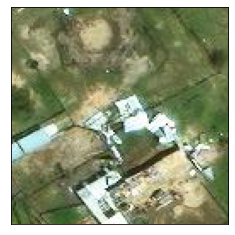

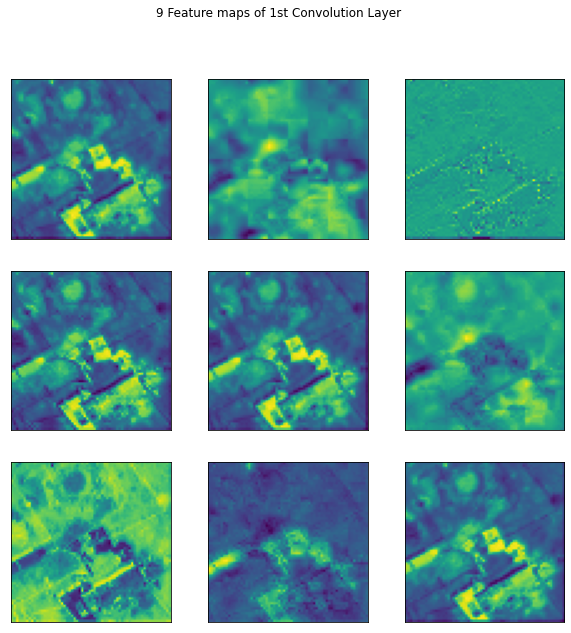

In [ ]:
# Generating Feature Maps from 2nd Layer i.e 1st Conv2D layer

img = mp_image.imread('gdrive/My Drive/post_hurricane/test_another/damage/-97.001414_28.622662.jpeg')
feature_maps = get_feature_maps(model, 2, img)[:9]

plt.imshow(img)
plt.xticks([])
plt.yticks([])

fig,axes = plt.subplots(3,3,figsize=(10,10))
for i,ax in enumerate(axes.ravel()):
  ax.imshow(feature_maps[i][:][:])
  ax.set_xticks([])
  ax.set_yticks([])
  fig.suptitle('9 Feature maps of 1st Convolution Layer', fontsize = 12)

## Model Evaluation

In [ ]:
# Building test_generator and test_another_generator for Model evaluation

test_generator=datagen.flow_from_directory('gdrive/My Drive/post_hurricane/test', target_size=(224,224),batch_size = batch_size,shuffle = False)
test_another_generator=datagen.flow_from_directory('gdrive/My Drive/post_hurricane/test_another', target_size=(224,224),batch_size = batch_size, shuffle = False)

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


In [ ]:
# Saved in CSV, can be loaded and reused for building the Confusion matrix of test data

# y_pred_test = model.predict(test_generator)
# y_pred_test = [np.argmax(p) for p in y_pred_test]
# y_pred_test = pd.DataFrame(y_pred_test,columns=['y_pred_test']).to_csv('/content/gdrive/MyDrive/Colab Notebooks/y_pred_test.csv')

In [ ]:
# Saved in CSV, can be loaded and reused for building the Confusion matrix of test_another data

# y_test_another = model.predict(test_another_generator)
# y_test_another = [np.argmax(p) for p in y_test_another]
# y_test_another = pd.DataFrame(y_test_another,columns=['y_test_another']).to_csv('/content/gdrive/MyDrive/Colab Notebooks/y_test_another.csv')

In [ ]:
# Loading y_pred_test (predictions from test data) from CSV and creating confusion matrix

fh = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/y_pred_test.csv')
y_pred_test = fh['y_pred_test'].tolist()

confusion_matrix(test_generator.classes, y_pred_test)

array([[958,  42],
       [  5, 995]])

> We can infer from the above confusion matrix: 

- 958 out of 1000 damaged buildings are predicted correctly by the model. Hence, the recall is 958/1000 i.e. **0.958**

- 995 out of 1000 non damaged buildings are predicted correctly by the model.

- Precision of the model over test data is 958/(958+5) i.e. 0.994

- % Accuracy of the model over test data is 1953/2000 i.e. **97.65%**


In [ ]:
# Loading y_test_another (predictions from test_another) from CSV and creating confusion matrix

fh = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/y_test_another.csv')
y_test_another = fh['y_test_another'].tolist()

confusion_matrix(test_another_generator.classes, y_test_another)

array([[7635,  365],
       [  11,  989]])

We can infer from the above confusion matrix:

7635 out of 8000 damaged buildings are predicted correctly by the model. Hence, the recall is 7635/8000 i.e. **0.954**

989 out of 1000 non damaged buildings are predicted correctly by the model.

Precision of the model over test_another data is 7635/(7635+11) i.e. 0.998

% Accuracy of the model over test data is 8624/9000 i.e. **95.82%**

## Visualising predictions on some images

In [ ]:
# Function to plot the image and the corresponding prediction of the model

def prediction(img_loc,ax):
    new_image = load_image(img_loc)
    pred = model.predict(new_image)
    classmap = {v:k for k,v in (train_generator.class_indices).items()}
    plot_img = mp_image.imread(img_loc);
    ax.imshow(plot_img)
    ax.set_title(f'Prediction: {classmap[pred.argmax(-1)[0]]} \n (with confidence: {str(pred[0][pred.argmax(-1)][0])[:4]})',fontsize=10)
    ax.axis('off')

In [ ]:
# Function for generation of GradCAM
def model_modifier(m):
  m.classifier_activation = 'linear'  

# Defining a function to generate saliency graphs
def gradcam_graph(model, img_path):

  # input image that is pre-processed
  input_image =  load_image(img_path)

  # predict on the input image
  y_pred = model.predict(input_image)
  
  # return the indices in decreasing order of predicted probability
  class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
  for i, class_idx in enumerate(class_idxs_sorted[:1]):

    # Define loss function for the class label.
    # The 'output' variable refer to the output of the model
    loss = lambda output: tf.keras.backend.mean(output[:, class_idx])   

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier=model_modifier,clone=False)
    # Generate heatmap with GradCAM
    cam = gradcam(loss,input_image,penultimate_layer=-1)
    cam = normalize(cam)   

    plot_gradcam_map(y_pred, i, class_idx, cam, input_image,img_path)



# Function to plot saliency map and gradcam

def plot_gradcam_map(y_pred, i, class_idx,cam,input_image,img_path):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
  
  classmap = {v:k for k,v in (train_generator.class_indices).items()}
  fig.suptitle(f'Prediction: {classmap[y_pred.argmax(-1)[0]]}', fontsize=20)
  ax[0].imshow(Image.open(img_path).resize((200, 200), Image.ANTIALIAS))
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  ax[1].imshow(input_image[0])                    # GradCAM activation 
  ax[1].imshow(heatmap, cmap='jet', alpha=0.5)    # overlay
  ax[1].set_title(f'Grad Map activation for target class: {classmap[class_idx]}')
  for axe in ax:
    axe.grid(False)
    axe.axis('off')
  

###Correctly classified images

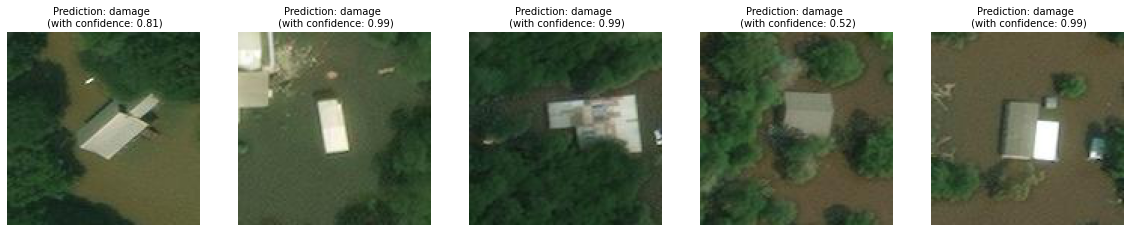

In [ ]:
fig,axes = plt.subplots(1,5,figsize=(20,20))
i=0
for b in [5,10,15,20,25]:
    prediction(test_generator.filepaths[b], axes[i])
    i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


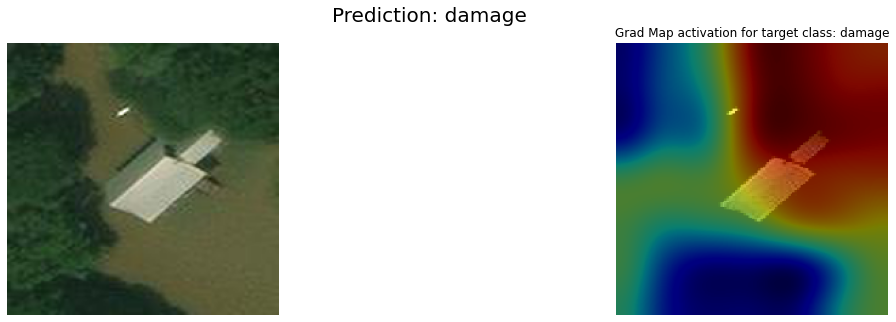

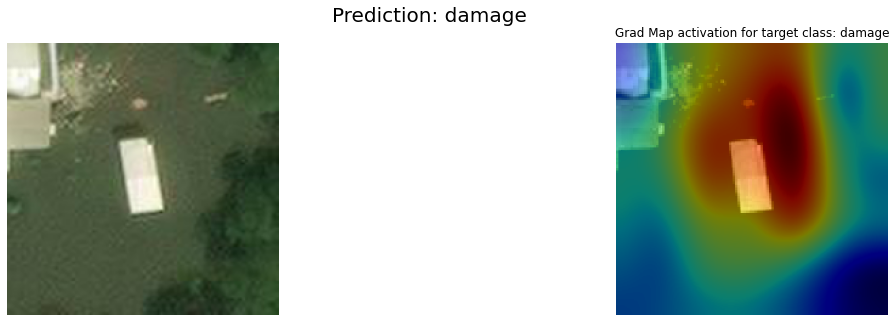

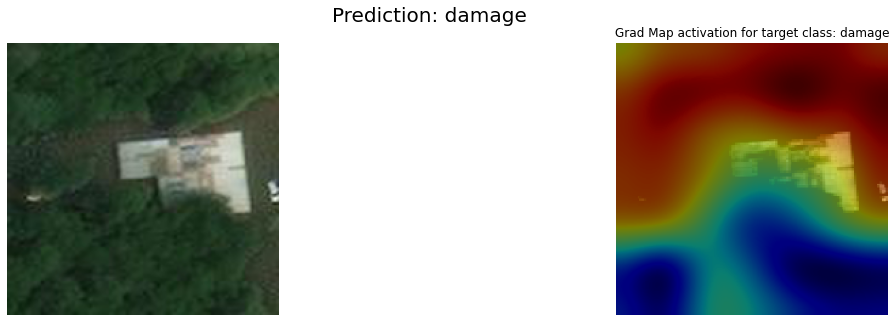

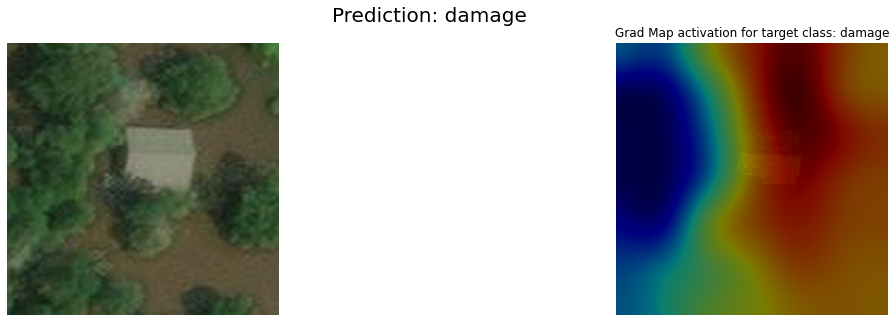

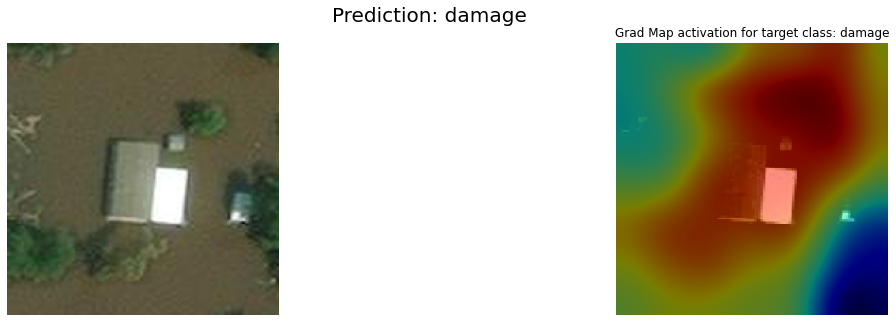

In [ ]:
# Generating Saliency Maps and GradCAM for some correctly classified images

for b in [5,10,15,20,25]:
  gradcam_graph(model, test_generator.filepaths[b])

###Incorrectly classified Images**

In [ ]:
# Making a list of indices of incorrectly classified images
list_incorrect=[]
for i in range(len(y_pred_test)):
  if (y_pred_test[i]!= test_generator.classes[i]):
    list_incorrect.append(i)

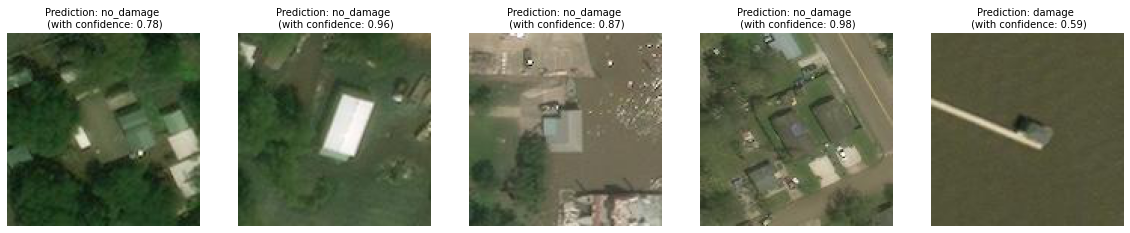

In [ ]:
# Plotting the incorrectly classified images along with the predictions for them
fig,axes = plt.subplots(1,5,figsize=(20,20))
i=0
for b in [10,11,20,36,42]:
    prediction(test_generator.filepaths[list_incorrect[b]], axes[i])
    i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


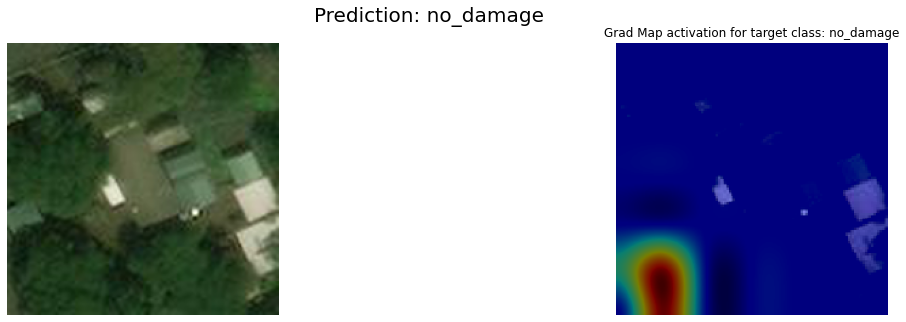

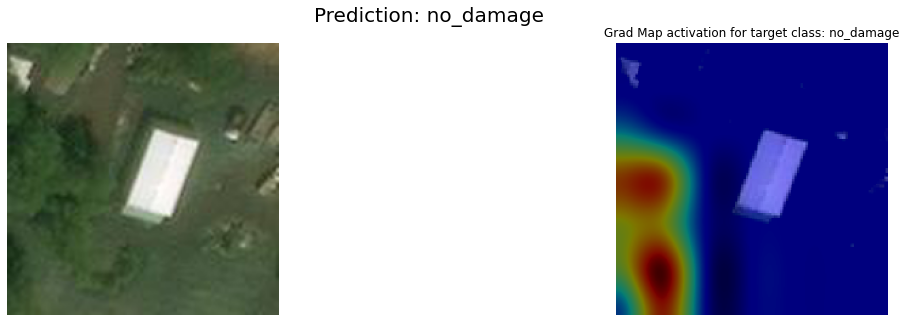

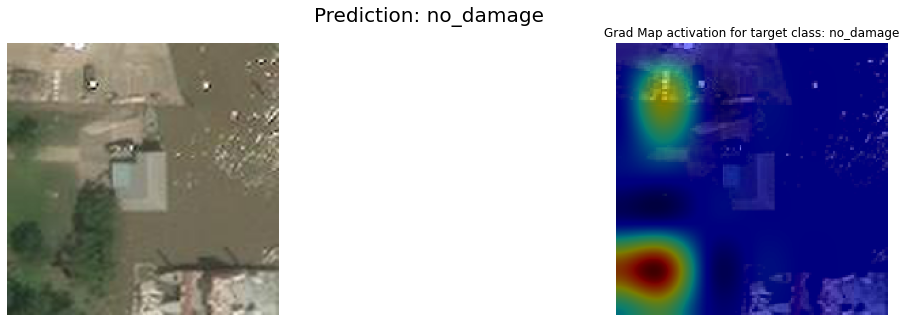

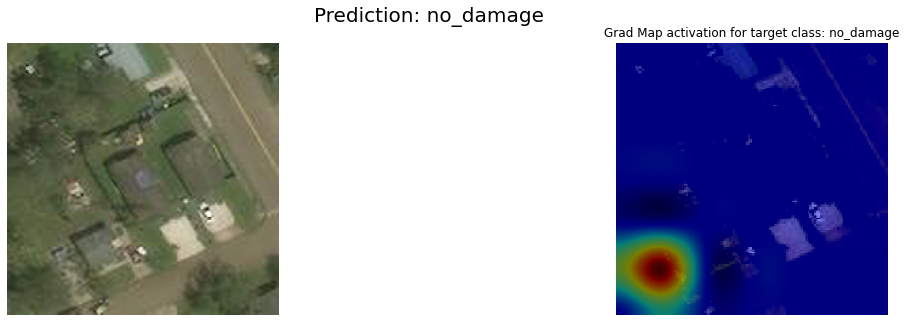

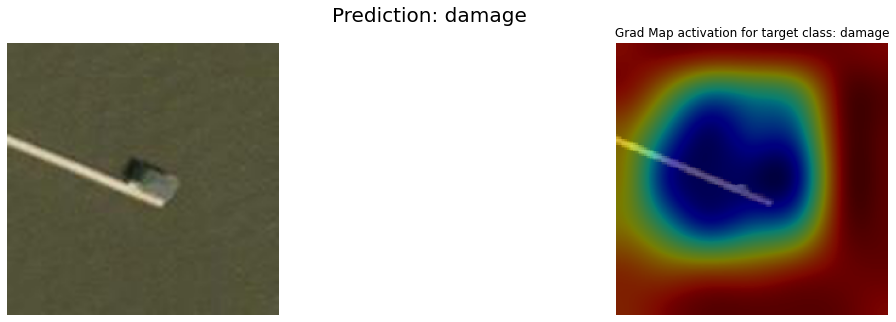

In [ ]:
# Generating Saliency Maps and GradCAM for some incorrectly classified images

for b in [10,11,20,36,42]:
  gradcam_graph(model, test_generator.filepaths[list_incorrect[b]])

####**Inferences**

**GradCAM**

We observe that for the *Damaged* class prediction, it highlights the important regions for the class activation - **flooded waters**

And for *Non-damaged* class prediction, the important regions for activation are centered around **trees and buildings**. 

## Conclusions

As seen above from the confusion matrices, we can conclude that the model is able to classify pretty good between damaged and non damaged images. The recall for damaged class is well above ~95%, which means that the rescue resources to cater the damaged areas can be channeled quite well with this model. The precision for the model is well above ~99% and the accuracy over test datasets is above ~95%.

